In [1]:
import numpy as np
import pandas as pd
from pystdf.IO import Parser
from pystdf.Writers import TextWriter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#https://github.com/cmars/pystdf/blob/master/pystdf/Importer.py

class MemoryWriter:
    def __init__(self):
        self.data = []
    def after_send(self, dataSource, data):
        self.data.append(data)
    def write(self,line):
        self.data.append(line)
    def flush(self):
        pass # Do nothing
        
def ImportSTDF(fname):
    with open(fname,'rb') as fin:
        p = Parser(inp=fin)
        storage = MemoryWriter()
        p.addSink(storage)
        p.parse()
    return storage.data
    
#capture tag """PTR"""
def STDF2DataFrame(fname):
    """ Convert STDF to a dictionary of DataFrame objects
    """
    data = ImportSTDF(fname)
    data_out = []
    for datum in data:
        datum_out = {}
        RecType = datum[0].__class__.__name__.upper()
        if RecType == "PTR":
            for k,v in zip(datum[0].fieldMap,datum[1]):
                datum_out[k[0]] = v
            data_out.append(datum_out)
    #convert dictionary to dataframe
    return pd.DataFrame.from_dict(data_out)

In [3]:
df = STDF2DataFrame("demofile.stdf")
#drop unused columns
df = df.drop(columns=['C_RESFMT','C_LLMFMT','C_HLMFMT','LO_SPEC','HI_SPEC'])
df.head()

,TEST_NUM,HEAD_NUM,SITE_NUM,TEST_FLG,PARM_FLG,RESULT,TEST_TXT,ALARM_ID,OPT_FLAG,RES_SCAL,LLM_SCAL,HLM_SCAL,LO_LIMIT,HI_LIMIT,UNITS
0,1000,1,0,0,0,-0.661094,glxy_SS_IH <> glxy_pin2,,14,0,0,0,-0.9,-0.4,v
1,1010,1,0,0,0,-0.650156,glxy_OSC <> glxy_pin3,,14,0,0,0,-0.9,-0.4,v
2,1020,1,0,0,0,-0.688281,glxy_OUTS <> glxy_pin4S,,14,0,0,0,-0.9,-0.4,v
3,1030,1,0,0,0,-0.692031,glxy_OUTF <> glxy_pin4F,,14,0,0,0,-0.9,-0.4,v
4,1040,1,0,0,0,-0.549219,glxy_VCCS <> glxy_pin5S,,14,0,0,0,-0.9,-0.4,v


In [4]:
#df.to_csv('out.csv', index=False)

In [5]:
def Cp(mylist, usl, lsl):
    arr = np.array(mylist)
    arr = arr.ravel()
    sigma = np.std(arr)
    Cp = float(usl - lsl) / (6*sigma)
    return Cp

def Cpk(mylist, usl, lsl):
    arr = np.array(mylist)
    arr = arr.ravel()
    sigma = np.std(arr)
    m = np.mean(arr)

    Cpu = float(usl - m) / (3*sigma)
    Cpl = float(m - lsl) / (3*sigma)
    Cpk = np.min([Cpu, Cpl])
    return Cpk

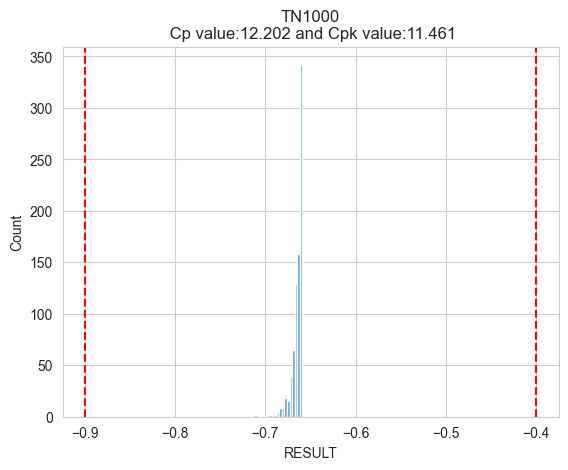

In [6]:
T1000_data = df[df['TEST_NUM']==1000]

# Specify specification limits
lsl = T1000_data['LO_LIMIT'].unique()[0]
usl = T1000_data['HI_LIMIT'].unique()[0]

#filter out of limit units
T1000_data = T1000_data[(T1000_data['RESULT'] < usl) & (T1000_data['RESULT'] > lsl)]

# Calculate the mean
T1000_mean = np.mean(T1000_data['RESULT'])
# Caculate Cp
T1000_Cp = Cp(T1000_data['RESULT'], usl, lsl)
# Caculate Cpk
T1000_Cpk = Cpk(T1000_data['RESULT'], usl, lsl)

sns.set_style("whitegrid")
plt.title(f"TN{1000}\n Cp value:{T1000_Cp:.3f} and Cpk value:{T1000_Cpk:.3f}")
sns.histplot(data=T1000_data['RESULT'], bins=20)
plt.axvline(lsl, color='r', linestyle="--")
plt.axvline(usl, color='r', linestyle="--")